In [2]:
import numpy as np
from src.vae2D import vae_model
from src.util import load_2Ddata
from pyeit import mesh
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from src.performance_eval import (compute_evaluation_metrics,
    plot_deviations_x_y, 
    plot_deviations_perm,
    plot_seq_recon_examples)
from tensorflow.keras.models import load_model
import os
import tensorflow as tf

2025-04-10 09:53:04.802168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744278784.817496 2097219 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744278784.822234 2097219 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 09:53:04.841680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1744278805.978006 2097219 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

**Loading Models**

In [7]:
def mapper(voltage, mapper, data_type):
    if mapper == "with_lstm":
        
        from src.lstm_mapper2D import lstm_mapper2D_model
        
        lstm_mapper = lstm_mapper2D_model()
        lstm_mapper.summary()
            
        if data_type == "sim": 
            lstm_mapper.load_weights("weights/lstm_sim.weights.h5")
            print("Weights of the LSTM mapper (for sim data) loaded successfully.")
        else:
            lstm_mapper.load_weights("weights/lstm_exp_2D.weights.h5")
            print("Weights of the LSTM mapper (for exp data) loaded successfully.")

        print("Generating latent representations...")
        
        pred_latent = lstm_mapper.predict(voltage)

    else:
        
        from src.mapper2D import no_lstm_mapper2D_model
        
        mapper = no_lstm_mapper2D_model()
        mapper.summary()

        if data_type == "sim":
            mapper.load_weights("weights/no_lstm_sim.weights.h5")
            print("Weights of the mapper without LSTM (for sim data) loaded successfully.")
        else:
            mapper.load_weights("weights/no_lstm_exp_2D.weights.h5")
            print("Weights of the mapper without LSTM (for exp data) loaded successfully.")
        
        print("Generating latent representations...")
        
        pred_latent = mapper.predict(voltage)

    return pred_latent

In [3]:
vae = vae_model()  
vae.build(input_shape=(None, 2840)) 
vae.load_weights("weights/vae2D.weights.h5")
print("Weights of VAE loaded successfully.")

Weights of VAE loaded successfully.


# load simulation data

In [4]:
voltage, gamma, pos = load_2Ddata("sim_data", "sim_data_set_1", data_type = "sim") 

#selection of data:
##########################################################

# sim_data/sim_data_set - circle trajectory, 5000 samples
# sim_data/sim_data_set_1 - eight figure trajectory, 5000 samples

##########################################################

Loading simulation data...
Normalizing data...
Data loading complete!


In [5]:
print(voltage.shape)
print(gamma.shape)

(4996, 4, 32, 32, 1)
(4996, 2840, 1)


# load experimental data

In [18]:
voltage, gamma, pos, _, _ = load_2Ddata("exp_data_2D", "exp_data_set_5", "exp") 

#selection of data:
##########################################################

#exp_data_2D/exp_data_set - eight, 1000 samples
#exp_data_2D/exp_data_set_1 - polynomial, 1000 samples
#exp_data_2D/exp_data_set_2 - circle, acceleration, 200 samples
#exp_data_2D/exp_data_set_3 - eight, 125 samples
#exp_data_2D/exp_data_set_4 - circle, 1000 samples
#exp_data_2D/exp_data_set_5 - square, 1000 samples

###########################################################



Loading experimental data...
Calculating absolute voltages...
Normalizing data...
Subtracting voltage measurements from empty tank...
Calculating mean of voltage differences...
Transforming position data...
(1000, 2)
Creating gamma...
(1000, 2840)
Processing sequences with mean...
Data loading complete!


In [19]:
print(voltage.shape)
print(gamma.shape)

(996, 4, 32, 32, 1)
(996, 2840, 1)


## generating prediction of conductivity distribution using recon model

In [25]:
pred_latent = mapper(voltage, "with_lstm", "exp") # "with_lstm" or "no_lstm"; "sim" or "exp"

gamma_pred = vae.decoder.predict(pred_latent).reshape(-1, 2840,1)

Model: "2D_lstm_mapper"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 4, 32, 32, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 4, 15, 15, 2)   │            20 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 4, 7, 7, 2)     │            38 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 4, 98)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 4, 64)          │         6,336 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,082 (86.26 KB)

 Trainable params: 22,082 (86.26 KB)

 Non-trainable params: 0 (0.00 B)

Gewichte des LSTM_Mappers erfolgreich geladen.
Generiere latente Räume...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [26]:
n_el = 32
mesh_obj = mesh.create(n_el, h0=0.05)

In [27]:
name = 'exp_no_lstm_spirale_circle'

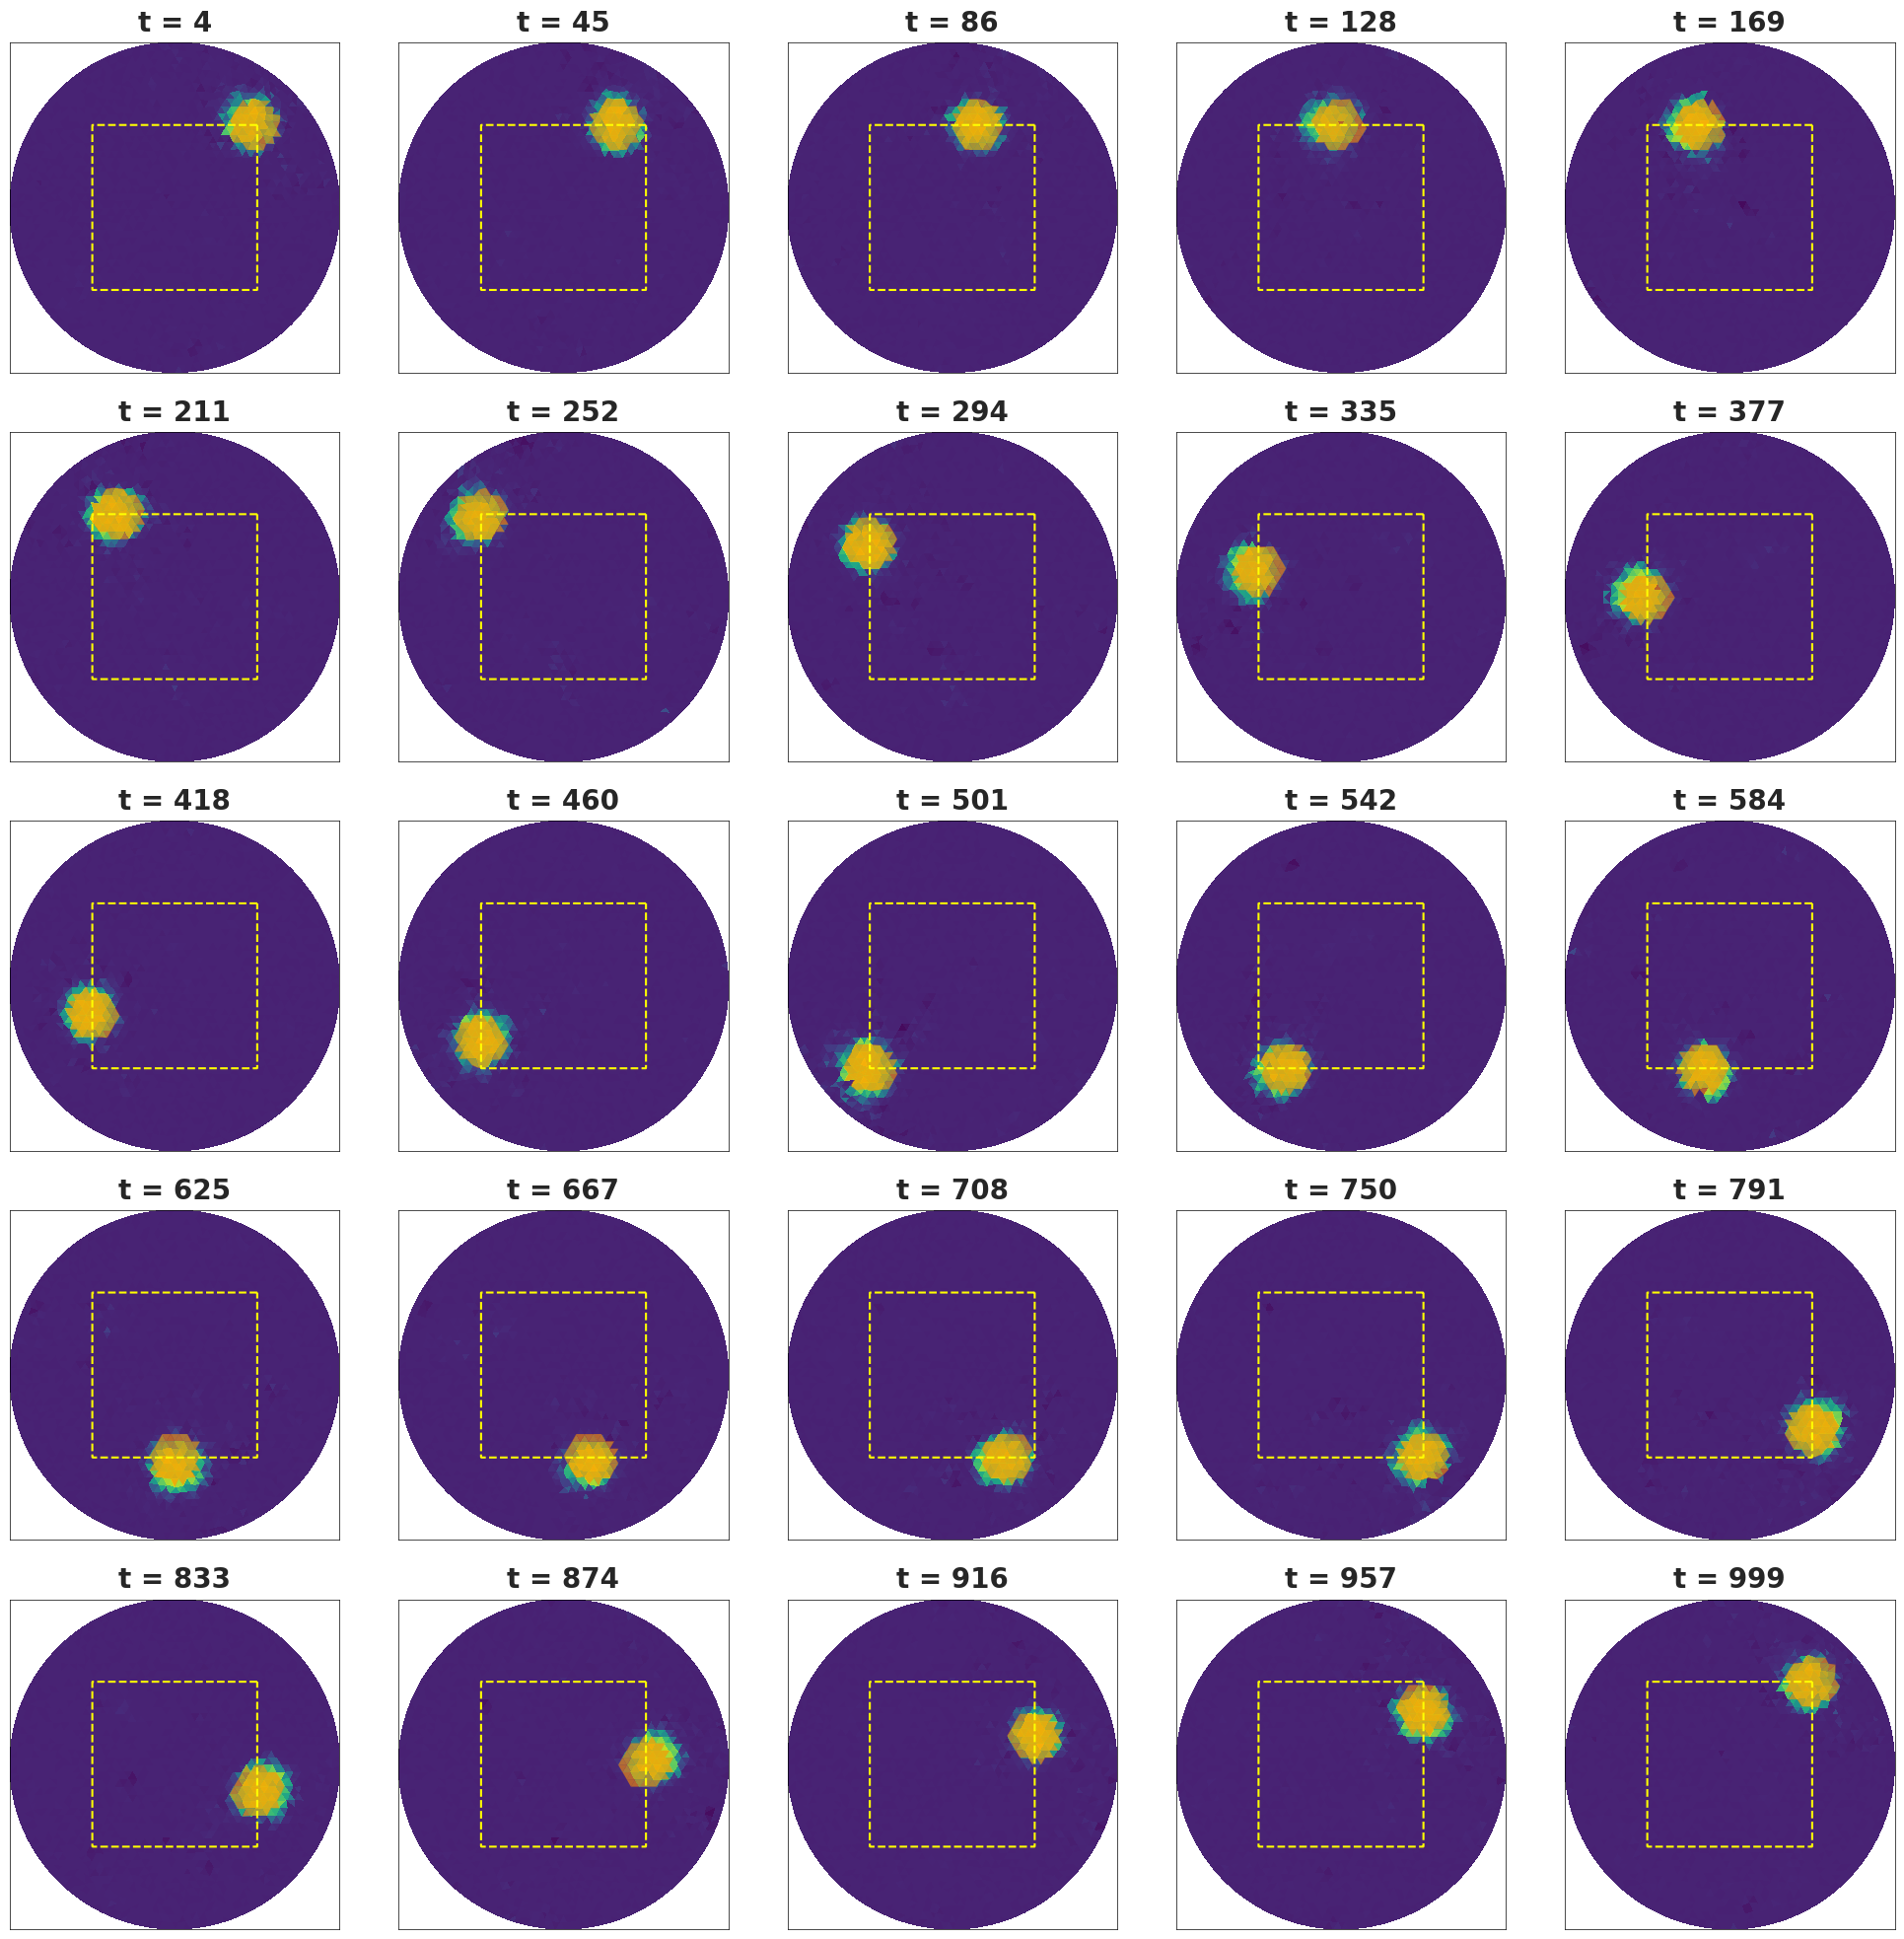

In [29]:
plot_seq_recon_examples(mesh_obj, 
                        gamma, 
                        gamma_pred, 
                        pos, 
                        save=False, 
                        fpath='results/',
                        fname = f'seq_reconstructions_{name}.pdf', num_plots=25)

/home/jy2353/.local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jy2353/.local/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


μx = 0.009
μy = 0.020
σx = 0.032
σy = 0.044
valid data points: 994


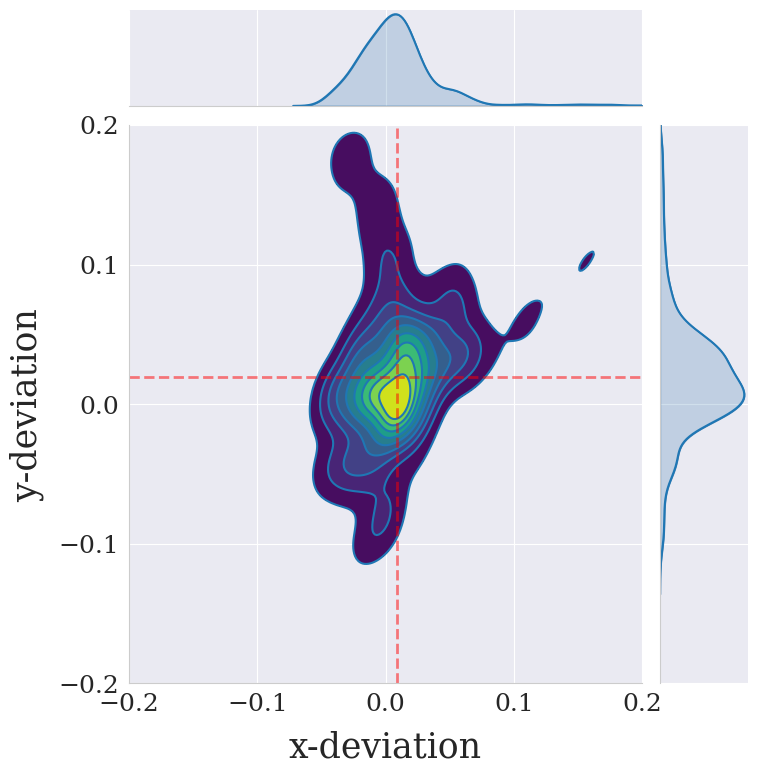

In [12]:
plot_deviations_x_y(
    gamma,
    gamma_pred,
    mesh_obj,
    save=False,
    fpath='results/',
    fname=f'deviation_plot_{name}',
    limits = (-0.20, 0.20),
    scale_factor = False                     #scale_factor = True, if experimental data is used
)

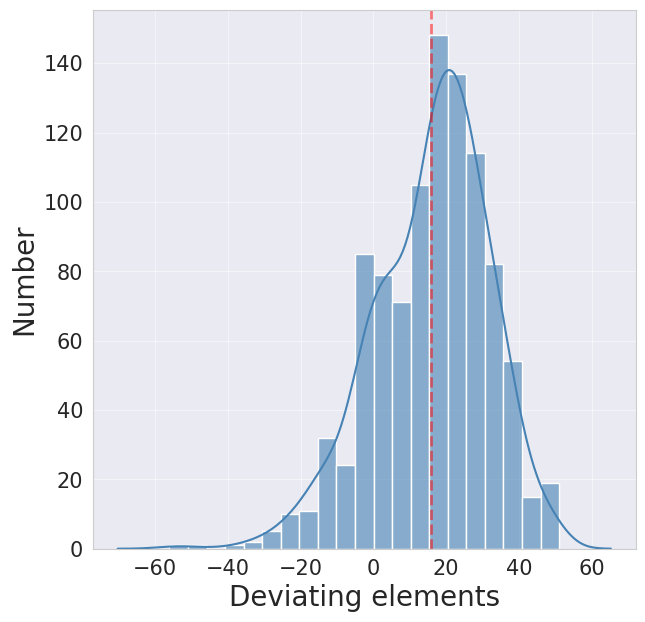

In [13]:
plot_deviations_perm(
    gamma,
    gamma_pred,
    mesh_obj,
    save=False,
    fpath='results/',  
    fname=f'perm_deviation_plot_{name}',   
    binwidth=5 
)